1. 이미지와 라벨로 모델 학습
1. 배경 후보 이미지 테스트
1. 진짜 배경 이미지 선별
1. 배경과 행인 이미지 합성
1. 재학습

In [1]:
#!pip install tensorflow_datasets

!pip install tensorflow_addons

In [2]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

from PIL import Image
from PIL import ImageFilter
import ast
import json
from glob import glob

In [3]:
#https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model

In [4]:
#https://github.com/tensorflow/addons/blob/v0.11.2/tensorflow_addons/image/__init__.py
from tensorflow_addons.image.color_ops import sharpness
from tensorflow_addons.image.filters import gaussian_filter2d
from tensorflow_addons.image.dense_image_warp import dense_image_warp

In [5]:
tf.__version__, tf.test.is_gpu_available()#('2.4.0-rc0', True) ('2.4.1', True)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


('2.4.1', True)

In [6]:
tf.keras.backend.clear_session()
#tf.config.optimizer.set_jit(False) # Start with XLA disabled.

In [7]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #CPU

In [8]:
class_names = ['bg', 'person', 'bicycle', 'lean']

padded_image_shape = (1024, 1920)
anchor_k = 9
num_classes_real = len(class_names)
num_classes = 10 + num_classes_real
max_data_m = 50000
use_zoom_up_data = False
use_pedestrian = False
use_visdrone = False
level_start = 4
level_end = 7
l1 = 1e-9
activation = 'swish'#'selu' is not converted to tflite
kernel_init = tf.initializers.he_normal()
edgecolors = np.random.rand(num_classes, num_classes_real) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)

In [9]:
path_Tongyoung = '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/'
os.path.isdir(path_Tongyoung)

True

In [10]:
forder_P_DESTRE = '/home/mvlab/Downloads/dataset/P-DESTRE/'
forder_P_DESTRE = '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/P-DESTRE/images/'

folder_weather = '/home/sogangori/Downloads/dataset/weather/'

names = ['fn','cname','id', 'x0', 'y0', 'w', 'h']
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)
path_weight = "weight/pedestrian_efficientDet-D3"

os.path.isdir(path_Tongyoung), os.path.isdir(forder_P_DESTRE)

(True, True)

In [11]:
paths_txt = glob(path_Tongyoung+'*/*.txt')
paths_img = glob(path_Tongyoung+'*/*')
len(paths_txt), len(paths_img)#(5, 10040)

(5, 10040)

In [12]:
paths_txt

['/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/mix1/image_label.txt',
 '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/도천1/도천1.txt',
 '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/도천2/도천2.txt',
 '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/미수1/미수1.txt',
 '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/미수2/미수2.txt']

In [13]:
use_weather_effect = os.path.isdir(folder_weather)
use_weather_effect, folder_weather

(False, '/home/sogangori/Downloads/dataset/weather/')

In [14]:
weather_images = []
if use_weather_effect:
    path_weathers = glob(folder_weather + '*.*')
    if len(path_weathers)>0:
        for path_weather in path_weathers:            
            image = Image.open(path_weather) 
            weather_images.append(image)            
            plt.imshow(image)
            plt.show()
    else:
        use_weather_effect = False

### video label load

In [15]:
paths_txt

['/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/mix1/image_label.txt',
 '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/도천1/도천1.txt',
 '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/도천2/도천2.txt',
 '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/미수1/미수1.txt',
 '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/미수2/미수2.txt']

In [16]:
list_df_TongYoung = []

for path_txt in paths_txt:
    df = pd.read_csv(path_txt, header=None, names=names)    
    index_last_sep = path_txt.rindex(os.sep)
    path_self_folder = path_txt[:index_last_sep+1]
    annot_file_name = path_txt.split(os.sep)[-1]
    print(path_self_folder, annot_file_name, df.shape)
    for i in range(len(df)):
        file_name = df.loc[i, 'fn']
        
        if '.' not in str(file_name):
            file_name = '0' + str(file_name) + '.jpg'
        
        full_path = path_self_folder + file_name        
        df.loc[i, 'exist'] = os.path.isfile(full_path)
        df.loc[i, 'path'] = full_path        
    
    exist = df['exist'].astype(int)
    print(exist.mean())
    df = df[exist > 0].drop(columns='exist')
    if len(df) > 0:
        list_df_TongYoung.append(df)

/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/mix1/ image_label.txt (758, 7)
0.8456464379947229
/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/도천1/ 도천1.txt (978, 7)
0.8353783231083844
/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/도천2/ 도천2.txt (2793, 7)
0.8918725384890799
/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/미수1/ 미수1.txt (1085, 7)
1.0
/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/미수2/ 미수2.txt (2291, 7)
1.0


In [17]:
df_TongYoung = pd.concat(list_df_TongYoung, axis=0)
df_TongYoung.shape#3566, 4315, 4644, 6052, 7843, 8652

(7325, 8)

In [18]:
df_TongYoung.cname.unique()

array(['person', 'bicycle', 'lean'], dtype=object)

In [19]:
df_TongYoung

,fn,cname,id,x0,y0,w,h,path
0,165721_raw.jpg,person,-1,67,851,18,43,/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestri...
1,165726_raw.jpg,person,-1,170,863,22,51,/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestri...
2,165731_raw.jpg,person,-1,360,870,18,39,/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestri...
3,165736_raw.jpg,person,-1,540,872,24,50,/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestri...
4,165741_raw.jpg,person,-1,560,892,23,49,/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestri...
...,...,...,...,...,...,...,...,...
2286,02688.png,person,-1,1001,566,31,76,/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestri...
2287,02688.png,person,-1,1017,670,50,117,/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestri...
2288,02689.png,person,-1,1091,475,21,47,/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestri...
2289,02690.png,person,-1,1108,433,16,27,/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestri...


In [20]:
df_img = df_TongYoung
df_img.shape#(409, 8), (7325, 8)

(7325, 8)

### P-DESTRE load

In [21]:
PDESTRE_columns = ['frame', 'ID', 'x', 'y', 'w', 'h', 'head', 'yaw', 'pitch', 'roll',          
          'gender', 'age', 'height', 'body volume', 'ethnicity', 'hair color', 'hairstyle', 'beard', 'mustache', 'glasses', 
           'head accessories', 'upper cloth', 'lower cloth', 'feet', 'accessories', 'action']
len(PDESTRE_columns)

26

In [22]:
gender_k = 2
body_volumn_k = 3
upper_cloth_k = 12
label_attribute_k = 8

In [23]:
df = df_img.drop(columns='fn')
df['id']= 1 #finetune
df['gender_'] = 0
df['body volume_'] = 0
df['upper cloth_'] = 0
df.shape

(7325, 10)

In [24]:
df.isna().sum().sum(), df['path'].nunique()

(0, 3785)

In [25]:
df = df.dropna()
df.shape

(7325, 10)

In [26]:
df['path'].nunique()

3785

In [27]:
class_names, class_names.index('person')

(['bg', 'person', 'bicycle', 'lean'], 1)

In [28]:
def parsing_annotation(df):
    annotation = dict()
    for i in range(len(df)):
      
        row = df.iloc[i].values
        cname, iden, x0, y0, w, h, path, gender, body_volume, upper_cloth = row
        x1 = x0 + w
        y1 = y0 + h
        if i%10000==0:
            print(i, row)
            
        cls = 1
        if cname in class_names:            
            cls = class_names.index(cname)
        
        if use_pedestrian:
            cls = iden # land 
            
        bbox = np.array([x0, y0, x1, y1, cls, gender, body_volume, upper_cloth]).reshape((1, -1))        

        path_image = path#finetune
        if not os.path.isfile(path_image):
            print('not exist', path_image)
            continue
            
        if path_image in annotation.keys():
            pre_bbox = annotation[path_image]
            new_bbox = np.concatenate((pre_bbox, bbox), axis=0)
            #cls_bbox = np.stack(cls_bbox, 0)#.reshape([-1, 6])
            #annotation[path_image].extend(new_bbox)
            annotation[path_image] = new_bbox
        else:
            annotation[path_image] = bbox        
    return annotation

In [29]:
annotation = parsing_annotation(df)
len(annotation)


0 ['person' 1 67 851 18 43
 '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/mix1/165721_raw.jpg'
 0 0 0]


3785

### image load

In [30]:
def crop_bbox_image(image, boxes):
    img_objects = []
    image = np.array(image)
    for box in boxes:        
        box = box.astype(np.int)
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1        
        crop_image_arr = image[y1:y2, x1:x2]
        ch, cw, cc = crop_image_arr.shape
        if ch>1 and cw>1:
            img_objects.append(crop_image_arr)
        else:
            print('crop_bbox_image', x2-x1, y2-y1, 'crop_image_arr.shape', crop_image_arr.shape)
        
    return img_objects
    
    
def attach_crop_image(image, boxes, max_crop=200):
        
    crop_bbox_arr = crop_bbox_image(image, np.array(boxes)[:max_crop])
    bbox_k = len(crop_bbox_arr)
    max_col = 30
    
    if bbox_k > 0:
        img_h, img_w, img_c = image.shape
        object_img_w = img_w//bbox_k        
        resize_h = img_h // 8
        resize_w = img_w // bbox_k  
        resize_w = min(max(resize_w, img_w//max_col), img_w//8)
        
        footer_h = resize_h * (1 + (bbox_k-1)//max_col)
        footer = np.zeros((footer_h, img_w, img_c), np.uint8)
        
        for i in range(min(bbox_k, max_crop)):
            crop_arr = crop_bbox_arr[i]
            crop_img = Image.fromarray(crop_arr)                
            crop_img = crop_img.resize((resize_w, resize_h))
            crop_arr_resized = np.array(crop_img)
            offset_y = (i//max_col) * resize_h
            offset_x = (i%max_col) * resize_w
            footer[offset_y:offset_y+resize_h, offset_x:offset_x+resize_w] = crop_arr_resized

        seperate_line = np.zeros_like(footer[:2])
        image = np.concatenate((image, seperate_line, footer), axis=0)    
    return image    

In [31]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)    
    
    img_h, img_w, img_c = image.shape
    
    image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        
        color = edgecolors[min(len(edgecolors)-1,int(cls))]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 70:
            #score_txt = class_names[int(cls)]
            score_txt = str(int(cls))
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]            
            bbox = sample_box[:, :4]
            label = sample_box[:, 4]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [32]:
def load_xy(annotation, rescale=1, stride=1, cut_top=False, size_cut=False):
    input_list = []
    bbox_list = []
    path_list = []
    for path_image in annotation:
        if stride!=1 and np.random.randint(1, 1+stride)%stride!=0:
            continue
            
        cls_bbox = annotation[path_image]                
        bbox = np.array(cls_bbox[:, :4])
        attribute = cls_bbox[:, 4:]

        img = Image.open(path_image)
        scale = np.array((img.width, img.height, img.width, img.height))
        if rescale!=1:
            img = img.resize((img.width//rescale, img.height//rescale))

        img_arr = np.array(img)
        if img_arr.ndim < 3:
            print('warn dimension', img_arr.ndim, path_image)
            continue
        if cut_top:#h1080 > h1024
            cut_top_h = 1080 - 1024
            scale = np.array((img.width, img.height-cut_top_h, img.width, img.height-cut_top_h))
            bbox = bbox - np.array((0, cut_top_h, 0, cut_top_h)).reshape(-1, 4)
            img_arr = img_arr[cut_top_h:]
        
        scale = np.reshape(scale, (1, 4))
        
        try:
            std_v = np.std(img_arr)
            if std_v < 3:
                print('std_v', std_v)
                continue
        except:
            print('error', path_image)
            continue

        bbox_norm = bbox.astype(np.float) / scale.astype(np.float)
        cls_bbox_norm = np.concatenate((bbox_norm, attribute), axis=1)

        if size_cut:                
            box_height = cls_bbox_norm[:, 3] - cls_bbox_norm[:, 1]
            box_height_max = np.max(box_height)
            if box_height_max < 0.05 or box_height_max > 0.2:
                continue

        input_list.append(img_arr)
        bbox_list.append(cls_bbox_norm)
        path_list.append(path_image)
        if len(input_list)%100==0:        
            print(len(annotation), len(input_list), len(bbox_list))   
        if len(input_list) > max_data_m:
            break       

    print(len(input_list), len(bbox_list))
    return input_list, bbox_list

In [33]:
input_list, bbox_list = load_xy(annotation, cut_top=True)
#error /home/mvlab/Downloads/dataset/통영/도천2/01748.png

3785 100 100
3785 200 200
3785 300 300
3785 400 400
3785 500 500
3785 600 600
3785 700 700
3785 800 800
3785 900 900
3785 1000 1000
3785 1100 1100
3785 1200 1200
3785 1300 1300
3785 1400 1400
3785 1500 1500
3785 1600 1600
3785 1700 1700
3785 1800 1800
warn dimension 0 /media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/image/도천2/02399.png
3785 1900 1900
3785 2000 2000
3785 2100 2100
3785 2200 2200
3785 2300 2300
3785 2400 2400
3785 2500 2500
3785 2600 2600
3785 2700 2700
3785 2800 2800
3785 2900 2900
3785 3000 3000
3785 3100 3100
3785 3200 3200
3785 3300 3300
3785 3400 3400
3785 3500 3500
3785 3600 3600
3785 3700 3700
3784 3784


In [34]:
len(input_list)

3784

(7324, 8) 3.0


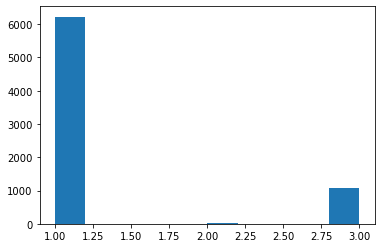

In [35]:
cbbox = np.concatenate(bbox_list, 0)
print(cbbox.shape, np.max(cbbox[:, 4])) # basic:1736 + P-DESTRE > 9757
h = plt.hist(cbbox[:, 4])

In [ ]:
display_data(input_list, bbox_list, stride=1000)

In [37]:
len(input_list)#, len(input_list_PDESTRE)#, len(list_visdrone_x)

3784

(7324, 8) 3.0


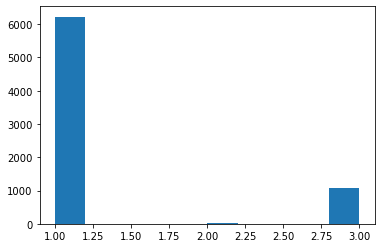

In [38]:
cbbox = np.concatenate(bbox_list, 0)
print(cbbox.shape, np.max(cbbox[:, 4])) # basic:1736 + P-DESTRE > 9757
h = plt.hist(cbbox[:, 4])

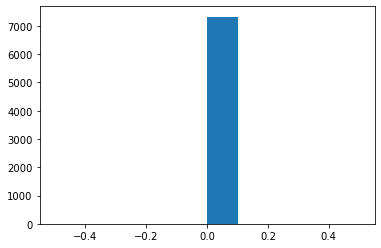

In [39]:
h = plt.hist(cbbox[:, -1])

In [40]:
cbbox = np.concatenate(bbox_list, 0)

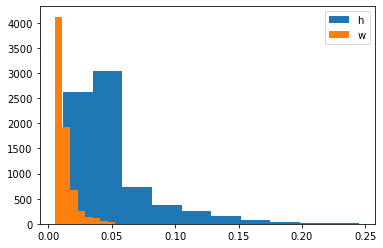

In [41]:
box_w = cbbox[:, 2] - cbbox[:, 0]
box_h = cbbox[:, 3] - cbbox[:, 1]
h = plt.hist(box_h, label='h')
h = plt.hist(box_w, label='w')
plt.legend()

In [42]:
np.corrcoef(box_w, box_h)

array([[1.        , 0.88032902],
       [0.88032902, 1.        ]])

In [43]:
cbbox.shape

(7324, 8)

In [44]:
def tile_object(X, BBOX, scope=0.5, min_cls=1):
    
    crop_xs = []
    crop_bboxs = []
    for i in range(len(X)):
        x = X[i]
        img_h, img_w, img_c = x.shape
        bbox = BBOX[i]
        #print('len', len(x), len(bbox), x.shape, bbox.shape)
        
        x0 = bbox[:, 0]
        y0 = bbox[:, 1]
        x1 = bbox[:, 2]
        y1 = bbox[:, 3]
        cls = bbox[:, 4]
        attributes = bbox[:, 4:]
        
        if not np.any(cls - 0.1 > min_cls):
            continue
            
        box_h = y1 - y0
        box_w = x1 - x0
        box_y_min = np.min(y0)
        box_x_min = np.min(x0)        
        box_y_max = np.max(y1)
        box_x_max = np.max(x1)        
        if box_y_max - box_y_min < scope and box_x_max - box_x_min < scope:
            
            cx = np.mean((box_x_min + box_x_max)/2)
            
            if cx < scope:
                tx0 = np.maximum(0, cx - scope/2)
                tx1 = tx0 + scope
            elif cx > 1 - scope:
                tx1 = np.minimum(1.0, cx + scope/2)
                tx0 = tx1 - scope
            else:
                tx0 = cx - scope/2
                tx1 = cx + scope/2                
                        
            tbox = np.stack(((x0 - tx0)/scope, y0, (x1 - tx0)/scope, y1), axis=1)            
            tbox = np.concatenate((tbox, attributes), -1)
            
            img_x0 = int(tx0 * img_w)
            img_x1 = img_x0 + int(img_w*scope)
            timg = x[:, img_x0:img_x1]
            
            img = Image.fromarray(timg)
            dst_w = int(padded_image_shape[1]*scope)
            img_resized = img.resize((dst_w, padded_image_shape[0]))
            arr_resized = np.array(img_resized)            
            
            crop_xs.append(arr_resized)
            crop_bboxs.append(tbox)
    return crop_xs, crop_bboxs


In [45]:
def tile_object_biggest_center(X, BBOX, scope=0.5, min_cls=1):
    
    crop_xs = []
    crop_bboxs = []
    for i in range(len(X)):
        x = X[i]
        img_h, img_w, img_c = x.shape
        bbox = BBOX[i]
        #print('len', len(x), len(bbox), x.shape, bbox.shape)
                
        cls = bbox[:, 4]
        
        if not np.any(cls - 0.1 > min_cls):
            continue            
    
        box_size = (bbox[:, 2] - bbox[:, 0]) * (bbox[:, 3] - bbox[:, 1])
        box_max_index = np.argmax(box_size)
        
        #print('box_max_index', box_max_index)
        box_center = bbox[box_max_index]
        #print('box_center', box_center)
                    
        cx = (box_center[0] + box_center[2])/2        

        if cx < scope:
            tx0 = np.maximum(0, cx - scope/2)
            tx1 = tx0 + scope
        elif cx > 1 - scope:
            tx1 = np.minimum(1.0, cx + scope/2)
            tx0 = tx1 - scope
        else:
            tx0 = cx - scope/2
            tx1 = cx + scope/2
            
        cond0 = bbox[:, 0] > tx0
        cond1 = bbox[:, 2] < tx1
        cond = np.logical_and(cond0, cond1)
        bbox = bbox[cond]
        cls = bbox[:, 4]
        attributes = bbox[:, 4:]
        
        x0 = bbox[:, 0]
        y0 = bbox[:, 1]
        x1 = bbox[:, 2]
        y1 = bbox[:, 3]
        tbox = np.stack(((x0 - tx0)/scope, y0, (x1 - tx0)/scope, y1), axis=1)            
        tbox = np.concatenate((tbox, attributes), -1)

        img_x0 = int(tx0 * img_w)
        img_x1 = img_x0 + int(img_w*scope)
        timg = x[:, img_x0:img_x1]

        img = Image.fromarray(timg)
        dst_w = int(padded_image_shape[1]*scope)
        img_resized = img.resize((dst_w, padded_image_shape[0]))
        arr_resized = np.array(img_resized)            

        crop_xs.append(arr_resized)
        crop_bboxs.append(tbox)
    return crop_xs, crop_bboxs


In [46]:
def attach_tiled_data_anisize(X, BBOX, row=2, col=2):
    m = len(X)
    attach_m = int(np.ceil(m/(row*col)))
    attach_xs = []
    attach_bboxs = []
    img_h, img_w, img_c = X[0].shape
    for i in range(attach_m):
        bg_color = np.median(X[i])
        attach_xs.append(bg_color + np.zeros((img_h*row, img_w*col, img_c)))    
        attach_bboxs.append([])
    
    m_rand = np.arange(m)
    np.random.shuffle(m_rand)
    for i in range(len(m_rand)):
        j = i#m_rand[i]
        x = X[j]
        bbox = BBOX[j]        
        img_h, img_w, img_c = x.shape
        ti = i//(row*col)
        ty = i%(row*col)//col
        tx = i%(row*col)%col
        dst_y0 = ty * img_h
        dst_y1 = dst_y0 + img_h
        dst_x0 = tx * img_w
        dst_x1 = dst_x0 + img_w
               
        attach_xs[ti][dst_y0:dst_y1, dst_x0:dst_x1] = x                    
        #cls, x0, y0, x1, y1, gender, body = np.split(bbox, label_attribute_k, -1)
        cbox, attributes = np.split(bbox, [4], -1)
        x0, y0, x1, y1 = np.split(cbox, 4, -1)
        
        x_scale = 1.0 / col
        y_scale = 1.0 / row
        x0 = x0 * x_scale + tx * x_scale
        y0 = y0 * y_scale + ty * y_scale
        x1 = x1 * x_scale + tx * x_scale
        y1 = y1 * y_scale + ty * y_scale
        bbox = np.concatenate((x0, y0, x1, y1, attributes), axis=1)        
        attach_bboxs[ti].extend(bbox)
            
    for i in range(len(attach_bboxs)):
        attach_bboxs[i] = np.stack(attach_bboxs[i], 0)
        
    return attach_xs, attach_bboxs

In [47]:
def attach_tiled_data(X, Y, col=2):
    row = 1
    m = len(X)
    use_m = (m // (row * col)) * (row * col)    
    print('use_m', use_m)
    X = np.array(X[:use_m])
    Y = np.array(Y[:use_m])
    
    x_split = np.split(X, col, axis=0)
    y_split = np.split(Y, col, axis=0)
        
    print('y_split', x_split[0].shape, x_split[1].shape, y_split[0].shape, y_split[1].shape)
        
    stride_i = len(x_split[0])
    scale_x = 1.0 / col
    
    list_Y = []    
    for i in range(stride_i):
        list_y = []
                
        for j in range(col):
            y = Y[i + stride_i * j]
            y_box = y[:, :4]
            y_attr = y[:, 4:]
            x0, y0, x1, y1 = np.split(y_box, 4, -1) 
            
            x0 = x0 * scale_x + j * scale_x
            x1 = x1 * scale_x + j * scale_x

            y_box = np.concatenate((x0, y0, x1, y1), -1)
            new_y = np.concatenate((y_box, y_attr), axis=-1)
            
            list_y.append(new_y)
        
        list_Y.append(np.concatenate(list_y, axis=0))
       
    
    x_concat = np.concatenate(x_split, axis=2)
    
    print('x_concat', x_concat.shape, 'type y',type(y_split))
        
    return list(x_concat), list_Y

In [48]:
def get_bg_paths():
    list_bg_jpg = glob(folder_water_bg + '*')
    list_bg_jpg0 = glob(folder_water_bg[:-1] + '0/*')
    print(len(list_bg_jpg), len(list_bg_jpg0))
    return list_bg_jpg0[1::2]#+ list_bg_jpg

In [49]:
def box_convert_cxy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate(( (y0+y1)/2, (x0+x1)/2 ), axis=1)

def box_swap_xy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate((x0, y0, x1, y1), axis=1)

def box_convert_to_xywh(boxes):
    return np.concatenate(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]], axis=-1,)

def box_convert_to_corners(boxes):    
    return np.concatenate(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1,)

def angle_to_radian(angle):
    return angle * np.pi/180

def rotate_images(X, angle):
    rotate_X = []
    for i in range(len(X)):        
        x = X[i]
        img_h = x.shape[0]
        img_w = x.shape[1]
        img = Image.fromarray(x)                
        img_rotated = img.rotate(angle)
        rotate_X.append(np.array(img_rotated))

    return rotate_X
    
def gen_rotate_data(X, BBOX, angle):
    rotate_xs = []
    rotate_bboxs = []
    m = len(X)
    for i in range(m):        
        x = X[i]
        
        bbox = BBOX[i]       
        attributes = bbox[:, 4:]        
        box = bbox[:, :4]
        box_xywh = box_convert_to_xywh(box)
        box_xy = box_xywh[:, :2] 
        box_wh = box_xywh[:, 2:] 
        box_uv = (np.reshape(box_xy, [-1, 2]) - 0.5) * 2
        
        img_h, img_w, img_c = x.shape
        img = Image.fromarray(x)        
        scale_mat = np.array([1, 0, 0, 1.0*img_h/img_w]).reshape((2,2))
        scale_mat_rev = np.array([1, 0, 0, 1.0*img_w/img_h]).reshape((2,2))
        
        angle = angle# + np.random.normal(scale=np.abs(angle))
        radian = angle_to_radian(angle)        
        rotate_mat = np.array([np.cos(radian), -np.sin(radian), np.sin(radian), np.cos(radian)])        
        rotate_mat = np.reshape(rotate_mat, (2, 2))
        box_uv_trans = np.matmul(box_uv, scale_mat)
        box_uv_trans = np.matmul(box_uv_trans, rotate_mat)
        box_uv_trans = np.matmul(box_uv_trans, scale_mat_rev)
        box_trans = (box_uv_trans + 1)/2
        box_trans_xy = np.reshape(box_trans, [-1, 2])
        box_trans_xywh = np.concatenate((box_trans_xy, box_wh), axis=1)
        box_trans = box_convert_to_corners(box_trans_xywh)
   
        #if np.min(box_trans)<0 or np.max(box_trans)>1: continue               
        
        bbox_trans = np.concatenate((box_trans, attributes), -1)
   
        img_rotated = img.rotate(angle)
        #plt.imshow(img_rotated)
        rotate_xs.append(np.array(img_rotated))
        rotate_bboxs.append(bbox_trans)

    return rotate_xs, rotate_bboxs        

display_data(input_list, bbox_list, stride=100)

In [50]:
m = len(input_list)
print('m', m)
s=1
input_list_train = input_list[::s]
input_list_test = input_list[1::2]
bbox_list_train = bbox_list[::s]
bbox_list_test = bbox_list[1::2]
print('bbox_list_train', len(bbox_list), len(bbox_list_train), len(bbox_list_test))

m 3784
bbox_list_train 3784 3784 1892


crop_x, crop_bbox = tile_object(input_list_train[::s], bbox_list_train[::s], scope=0.25, min_cls=2)

len(crop_x)

In [51]:
s=1
crop_xs, crop_bboxs = tile_object_biggest_center(input_list_train[::s], bbox_list_train[::s], scope=1/7, min_cls=0)
len(crop_xs)

3784

s = 2
crop_xs, crop_bboxs = tile_object(input_list_train[::s], bbox_list_train[::s], scope=1/7, min_cls=0)
print('crop_xs', len(crop_xs), len(crop_bboxs), crop_xs[0].shape, crop_bboxs[0])#764, 778, 2973

display_data(crop_xs, crop_bboxs, stride=100)

In [52]:
s = 1
rotate_x, rotate_bbox = gen_rotate_data(crop_xs[::s], crop_bboxs[::s], angle=-1.0)
rotate_x0, rotate_bbox0 = gen_rotate_data(crop_xs[1::s], crop_bboxs[1::s], angle=1.0)
rotate_x1, rotate_bbox1 = gen_rotate_data(crop_xs[::s], crop_bboxs[::s], angle=-0.5)
rotate_x2, rotate_bbox2 = gen_rotate_data(crop_xs[1::s], crop_bboxs[1::s], angle=0.5)
rotate_x.extend(rotate_x0)
rotate_x.extend(rotate_x1)
rotate_x.extend(rotate_x2)
rotate_bbox.extend(rotate_bbox0)
rotate_bbox.extend(rotate_bbox1)
rotate_bbox.extend(rotate_bbox2)



In [53]:
print('crop_xs', len(rotate_x), len(rotate_bbox))

crop_xs 15134 15134


In [54]:
rotate_x.extend(crop_xs)
rotate_bbox.extend(crop_bboxs)

In [55]:
print('crop_xs', len(rotate_x), len(rotate_bbox))

crop_xs 18918 18918


#attach 1x5
s = 1
crop_xs, crop_bboxs = tile_object(input_list_train[::s], bbox_list_train[::s], scope=0.2, min_cls=0)
attach_x5, attach_bbox5 = attach_tiled_data(crop_xs, crop_bboxs, col=5)
len(attach_x5)

display_data(attach_x5, attach_bbox5, stride=100)

In [61]:
#attach 1x6
s = 1
#crop_xs, crop_bboxs = tile_object(input_list_train[::s], bbox_list_train[::s], scope=1/6, min_cls=0)
#attach_x, attach_bbox = attach_tiled_data(rotate_x, rotate_bbox, col=8)
attach_x, attach_bbox = attach_tiled_data(crop_xs, crop_bboxs, col=7)
len(attach_x)

use_m 3780


<ipython-input-47-8fd7dc42fe89>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Y = np.array(Y[:use_m])


y_split (540, 1024, 274, 3) (540, 1024, 274, 3) (540,) (540,)
x_concat (540, 1024, 1918, 3) type y <class 'list'>


540

In [65]:
len(attach_x)

0

In [ ]:
display_data(attach_x, attach_bbox, stride=100)

attach_x.extend(attach_x5)
attach_bbox.extend(attach_bbox5)
attach_x.extend(attach_x6)
attach_bbox.extend(attach_bbox6)
len(attach_x)

In [64]:
insert_stride = len(input_list_train)//len(attach_x)
print('insert_stride', insert_stride)
for i in range(len(attach_x)):
    input_list_train.insert(i*insert_stride, attach_x.pop())
    bbox_list_train.insert(i*insert_stride, attach_bbox.pop())

print('bbox_list_train', len(input_list_train), len(bbox_list_train), len(bbox_list_test))

ZeroDivisionError: integer division or modulo by zero

input_list_train = attach_x
bbox_list_train = attach_bbox

input_list_train.extend(rotate_xs)
bbox_list_train.extend(rotate_bboxs)
len(input_list_train), len(rotate_xs)

rotate_xs, rotate_bboxs = gen_rotate_data(crop_xs, crop_bboxs, angle=1.0)
#rotate_xs_1, rotate_bboxs_1 = gen_rotate_data(crop_xs, crop_bboxs, angle=-0.5)

print('rotate_xs', len(rotate_xs), len(rotate_bboxs))
#rotate_xs.extend(rotate_xs_1)
#rotate_bboxs.extend(rotate_bboxs_1)

print('crop_xs', len(crop_xs), len(rotate_xs))

attach_x, attach_bbox = attach_tiled_data(rotate_xs, rotate_bboxs, row=1, col=2)
len(attach_x), len(attach_bbox)

display_data(list_visdrone_x, list_visdrone_y, stride=100)`

attach_xs.extend(attach_x)
attach_bboxs.extend(attach_bbox)

len(attach_xs), len(attach_bboxs)

input_list_train.extend(attach_xs)
bbox_list_train.extend(attach_bboxs)

In [66]:
print('len', len(input_list_train), len(input_list_test))

len 4797 1892


In [ ]:
display_data(input_list_test, bbox_list_test, stride=100)

In [ ]:
display_data(input_list_train, bbox_list_train, stride=1000)

In [70]:
def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.
    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.
    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


"""
## Computing pairwise Intersection Over Union (IOU)
As we will see later in the example, we would be assigning ground truth boxes
to anchor boxes based on the extent of overlapping. This will require us to
calculate the Intersection Over Union (IOU) between all the anchor
boxes and ground truth boxes pairs.
"""

def compute_iou(boxes1, boxes2):#compute_iou(anchor_boxes, gt_boxes)
    """Computes pairwise IOU matrix for given two sets of boxes
    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [71]:
level_end - level_start

3

In [72]:

"""
## Implementing Anchor generator
Anchor boxes are fixed sized boxes that the model uses to predict the bounding
box for an object. It does this by regressing the offset between the location
of the object's center and the center of an anchor box, and then uses the width
and height of the anchor box to predict a relative scale of the object. In the
case of RetinaNet, each location on a given feature map has nine anchor boxes
(at three scales and three ratios).
"""
class AnchorBox:
    """Generates anchor boxes.
    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.
    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.level_start = level_start
        self.level_end = level_end
        
        if anchor_k==9:
            self.aspect_ratios = [0.5, 1.0, 2.0]        
            self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        else:
            self.aspect_ratios = [1.0]        
            self.scales = [2 ** x for x in [0]]
                
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(self.level_start, self.level_end)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 196.0, 256.0]]                        
        self._areas = self._areas[:level_end - level_start]
        
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level
        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.
        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - self.level_start]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - self.level_start], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return tf.concat(anchors, axis=0)
    
    def get_anchors_check(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return anchors

In [73]:
level_start, level_end

(4, 7)

In [74]:
anchor_check = AnchorBox()

In [75]:
anchors = anchor_check.get_anchors_check(128,128)
for anchor in anchors:
    print(anchor.shape, anchor[-1])

(576, 4) tf.Tensor([120.       120.        71.83757   35.918785], shape=(4,), dtype=float32)
(144, 4) tf.Tensor([112.      112.      143.67514  71.83757], shape=(4,), dtype=float32)
(36, 4) tf.Tensor([ 96.       96.      287.35028 143.67514], shape=(4,), dtype=float32)


In [76]:
padded_image_shape, 128*8

((1024, 1920), 1024)

In [77]:
1080/1024, 1024/1080

(1.0546875, 0.9481481481481482)

In [78]:
128*7+32, 128*8-32

(928, 992)

In [79]:
"""
## Preprocessing data
Preprocessing the images involves two steps:
- Resizing the image: Images are resized such that the shortest size is equal
to 800 px, after resizing if the longest side of the image exceeds 1333 px,
the image is resized such that the longest size is now capped at 1333 px.
- Applying augmentation: Random scale jittering  and random horizontal flipping
are the only augmentations applied to the images.
Along with the images, bounding boxes are rescaled and flipped if required.
"""

def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.
    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1)
   
    return image, boxes

def resize_and_pad_image(
    image, mask_obj=None, min_side=1024.0, max_side=11333.0, jitter=[128*8, 128*8+1], stride=128.0
):
   
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    
    ratio = min_side / tf.reduce_min(image_shape)
    
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    if mask_obj!=None:
        mask_obj = tf.image.resize(mask_obj, tf.cast(image_shape, dtype=tf.int32))
    
    image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1]) 
    if mask_obj!=None:
        mask_obj = tf.image.pad_to_bounding_box(mask_obj, 0, 0, padded_image_shape[0], padded_image_shape[1])        
    if mask_obj!=None:
        return image, image_shape, ratio, mask_obj
    return image, image_shape, ratio

def resize_and_pad_image_bbox(
    image, bbox, mask_obj=None, min_side=1024.0, max_side=1024.0*4, jitter=[128*7+32, 128*8-32], stride=128.0
):
    #image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
    """Resizes and pads image while preserving aspect ratio.
    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.
    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    ratio_jitter = tf.random.uniform(tf.shape(image_shape), -32, 32, dtype=tf.float32)
    image_shape += ratio_jitter      
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    if mask_obj!=None:
        mask_obj = tf.image.resize(mask_obj, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1])
    if mask_obj!=None:
        mask_obj = tf.image.pad_to_bounding_box(mask_obj, 0, 0, padded_image_shape[0], padded_image_shape[1])        
    padded_image_shape = tf.cast(padded_image_shape, tf.float32)              
    pad_ratio = tf.cast(image_shape, tf.float32) / padded_image_shape
    bbox_padded = tf.stack(
        [
            bbox[:, 0] * pad_ratio[1],
            bbox[:, 1] * pad_ratio[0],
            bbox[:, 2] * pad_ratio[1],
            bbox[:, 3] * pad_ratio[0],
        ],
        axis=-1,
    )
    if mask_obj!=None:
        return image, padded_image_shape, ratio, bbox_padded, mask_obj    
    return image, padded_image_shape, ratio, bbox_padded


def unnormalize_box(bbox, image_shape):
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)    
    return bbox    


def preprocess_data(image, cls_bbox):
    """Applies preprocessing step to a single sample
    Arguments:
      sample: A dict representing a single training sample.
    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
     
    bbox = cls_bbox[:, :4]    
    attribute = tf.cast(cls_bbox[:, 4:], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)        
    image, image_shape, _, bbox = resize_and_pad_image_bbox(image, bbox)    
    bbox = unnormalize_box(bbox, image_shape)
    
    return image, bbox, attribute

def preprocess_test_data(image, cls_bbox):         
    bbox = cls_bbox[:, :4]    
    attribute = tf.cast(cls_bbox[:, 4:], dtype=tf.int32)
    
    image, image_shape, _ = resize_and_pad_image(image)
    bbox = unnormalize_box(bbox, image_shape)    
    
    return image, bbox, attribute

In [80]:
use_weather_effect

False

In [81]:
def image_color_augment(x):
    if tf.random.uniform(()) < -0.5:
        x_max = tf.reduce_max(x, [1, 2], True)
        x = x_max - x
    if tf.random.uniform(()) < -0.2:
        r, g, b = tf.split(x, 3, axis=-1)
        x = tf.concat((r, b, g), -1)
    elif tf.random.uniform(()) < -0.4:
        r, g, b = tf.split(x, 3, axis=-1)
        x = tf.concat((b, r, g), -1)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_hue(x, 0.08)
        x = tf.image.random_saturation(x, 0.6, 1.6)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_brightness(x, 0.05)
        x = tf.image.random_contrast(x, 0.7, 1.3)
    if tf.random.uniform(()) < -0.2:
        gray = tf.image.rgb_to_grayscale(x)
        x = tf.concat((gray, gray, gray), -1)        
    if tf.random.uniform(()) < -0.2:
        noise = tf.random.normal(tf.shape(x), stddev=tf.pow(tf.reduce_mean(x), 0.3))
        x += noise
    if tf.random.uniform(()) < 0.2:
        x = gaussian_filter2d(x, filter_shape=tuple(np.random.randint(1, 10, (2))), sigma=10)
        #x = gaussian_filter2d(x, filter_shape=np.random.randint(3, 10, (2)), sigma=10)
    if tf.random.uniform(()) < 0.2:        
        x = sharpness(x, factor=10)
    if tf.random.uniform(()) < 0.2:        
        if use_weather_effect:
            weather_k = len(weather_images)                            
            h = tf.shape(x)[1]
            w = tf.shape(x)[2]
            weather_image = weather_images[np.random.randint(weather_k)]
            weather_image = tf.image.resize(weather_image, tf.cast((h, w), dtype=tf.int32))
            weather_image = tf.expand_dims(weather_image, 0)
            x = (x // 3) * 2 + weather_image//3
            
    #x = tf.image.random_jpeg_quality(x, 0, 1.0)
    #x = tf.clip_by_value(x, 0, 1)
    
    return x

In [82]:
"""
## Encoding labels
The raw labels, consisting of bounding boxes and class ids need to be
transformed into targets for training. This transformation consists of
the following steps:
- Generating anchor boxes for the given image dimensions
- Assigning ground truth boxes to the anchor boxes
- The anchor boxes that are not assigned any objects, are either assigned the
background class or ignored depending on the IOU
- Generating the classification and regression targets using anchor boxes
"""

class LabelEncoder:
    """Transforms the raw labels into targets for training.
    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.
    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )    
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.3
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)#from anchor to object-box        
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)    
        positive_mask = tf.greater_equal(max_iou, match_iou)# not only this, but also need max iou cell
        
        positive_proposal_mask = tf.greater_equal(iou_matrix, match_iou)
        positive_mask = tf.reduce_any(positive_proposal_mask, axis=1)
        
        negative_mask = tf.less(max_iou, ignore_iou)
        
        max_iou_anchor = tf.reduce_max(iou_matrix, axis=0, keepdims=True) 
        max_iou_anchor_mask = tf.greater_equal(iou_matrix, max_iou_anchor)
        positive_max_mask = tf.reduce_any(max_iou_anchor_mask, axis=1)
        positive_mask = tf.logical_or(positive_mask, positive_max_mask)#new      
        
        negative_mask = tf.logical_and(negative_mask, tf.logical_not(positive_mask))
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))        
        
        return (
            matched_gt_idx,            
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(positive_max_mask, dtype=tf.float32),            
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _encode_sample(self, image_shape, gt_boxes, box_label):
        """Creates box and classification targets for a single sample"""
        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_label = tf.cast(box_label, dtype=tf.float32)
        
        bx, by, bw, bh = tf.split(gt_boxes, 4, -1)#finetune xywh original size
        
        bw = tf.squeeze(bw * bh, -1)
        bw = tf.sqrt(bw)
        
        cls_ids, cls_gender, cls_body, upper_cloth = tf.split(box_label, 4, -1)
        cls_ids = tf.squeeze(cls_ids, -1)
        cls_gender = tf.squeeze(cls_gender, -1)
        cls_body = tf.squeeze(cls_body, -1)
        upper_cloth = tf.squeeze(upper_cloth, -1)
        
        matched_gt_idx, positive_mask, positive_max_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        matched_gt_boxes_size = tf.reduce_prod(matched_gt_boxes[:, 2:], 1)
        matched_gt_boxes_size = tf.sqrt(matched_gt_boxes_size)        
        
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)    
        matched_bw = tf.gather(bw, matched_gt_idx)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        matched_gt_gender = tf.gather(cls_gender, matched_gt_idx)
        matched_cls_body = tf.gather(cls_body, matched_gt_idx)
        matched_upper_cloth = tf.gather(upper_cloth, matched_gt_idx)
        
        cls_target = tf.where(tf.not_equal(positive_mask, 1.0), 0.0, matched_gt_cls_ids)        
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -1.0, cls_target)
        #bw_thresh = tf.minimum(tf.reduce_min(matched_bw)+1, 10)
        #cls_target = tf.where(matched_bw < bw_thresh, -1.0, cls_target) #finetune
        
        attribute_target = tf.stack((cls_target, matched_bw, matched_gt_gender, matched_cls_body, matched_upper_cloth), -1)
        targets = tf.concat([box_target, attribute_target], axis=-1)        
        return targets
    
    def encode_batch(self, batch_images, gt_boxes, box_label):
        """Creates box and classification targets for a batch"""
        
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]
       
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], box_label[i])
            labels = labels.write(i, label)
        
        batch_images = tf.cast(batch_images, tf.float32)
        labels = labels.stack()
        
        #label = tf.concat((label, is_flipped_anchor), -1)
        return batch_images, labels      
    
    def encode_batch_train(self, batch_images, gt_boxes, cls):
        """Creates box and classification targets for a batch"""
        
        batch_images = image_color_augment(batch_images)#finetune        
        return self.encode_batch(batch_images, gt_boxes, cls)

In [83]:
def BifeaturePyramidNet(c345, again=False):
    filters = 128
    a2 = c345[0]
    a3 = c345[1]
    a4 = c345[2]
    a5 = c345[3]
    
    name_pre = ''
    if again:
        name_pre = 'arain_'
    
    regulizer  = tf.keras.regularizers.L2(l1)
    
    #b3 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #b4 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    
    a2_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'a2_0')(a2)
    #a3_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #a4_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    #a5_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a5)
    #a3_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #a4_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    
    a33 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'a33')(a3)
    a44 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'a44')(a4)
    a55 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'a55')(a5)
    a66 = Conv2D(filters*2, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'a66')(a5)
    
    a3_0, a3_1 = tf.split(a33, 2, -1)
    a4_0, a4_1 = tf.split(a44, 2, -1)
    a5_0, a5_1 = tf.split(a55, 2, -1)
    a6_0, a6_1 = tf.split(a66, 2, -1)
    
    b6 = a6_0
    
    a6_up = keras.layers.UpSampling2D(2)(a6_1)    
    b5 = keras.layers.Add()([a5_0, a6_up])  
        
    a5_up = keras.layers.UpSampling2D(2)(a5_1)    
    b4 = keras.layers.Add()([a4_0, a5_up])  
    
    b4_up = keras.layers.UpSampling2D(2)(b4)
    b3 = keras.layers.Add()([a3_0, b4_up])  
    
    b3_up = keras.layers.UpSampling2D(2)(b3)
    b2 = keras.layers.Add()([a2_0, b3_up])
    
    b2_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'b2_down')(b2)
    b3_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'b3_1')(b3)    
    c3 = keras.layers.Add()([a3_1, b3_1, b2_down])
    
    c3_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'c3_down')(c3)
    b4_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'b4_1')(b4)    
    c4 = keras.layers.Add()([a4_1, b4_1, c3_down])    
    
    c4_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'c4_down')(c4)
    b5_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'b5_1')(b5)    
    c5 = keras.layers.Add()([a5_1, b5_1, c4_down])    
    
    c5_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'c5_down')(c5)
    b6_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'b6_1')(b6)    
    c6 = keras.layers.Add()([a6_1, b6_1, c5_down])
   
    return c4, c5, c6

In [84]:
def BifeaturePyramidNet_3(c345):
    filters = 128
    a2 = c345[0]
    a3 = c345[1]
    a4 = c345[2]
    
    name_pre = '3_'
  
    regulizer  = tf.keras.regularizers.L2(l1)
    
    #b3 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #b4 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    
    a2_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'a2_0')(a2)
    #a3_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #a4_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    #a5_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a5)
    #a3_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #a4_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    
    a33 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'a33')(a3)
    a44 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'a44')(a4)
    a55 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'a55')(a5)
    a66 = Conv2D(filters*2, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'a66')(a5)
    
    a3_0, a3_1 = tf.split(a33, 2, -1)
    a4_0, a4_1 = tf.split(a44, 2, -1)
    a5_0, a5_1 = tf.split(a55, 2, -1)
    a6_0, a6_1 = tf.split(a66, 2, -1)
    
    b6 = a6_0
    
    a6_up = keras.layers.UpSampling2D(2)(a6_1)    
    b5 = keras.layers.Add()([a5_0, a6_up])  
        
    a5_up = keras.layers.UpSampling2D(2)(a5_1)    
    b4 = keras.layers.Add()([a4_0, a5_up])  
    
    b4_up = keras.layers.UpSampling2D(2)(b4)
    b3 = keras.layers.Add()([a3_0, b4_up])  
    
    b3_up = keras.layers.UpSampling2D(2)(b3)
    b2 = keras.layers.Add()([a2_0, b3_up])
    
    b2_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'b2_down')(b2)
    b3_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'b3_1')(b3)    
    c3 = keras.layers.Add()([a3_1, b3_1, b2_down])
    
    c3_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'c3_down')(c3)
    b4_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'b4_1')(b4)    
    c4 = keras.layers.Add()([a4_1, b4_1, c3_down])    
    
    c4_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'c4_down')(c4)
    b5_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'b5_1')(b5)    
    c5 = keras.layers.Add()([a5_1, b5_1, c4_down])    
    
    c5_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'c5_down')(c5)
    b6_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name=name_pre+'b6_1')(b6)    
    c6 = keras.layers.Add()([a6_1, b6_1, c5_down])
    
    return c4, c5, c6

inputs = Input(shape=(3, 3, 2))  # 18   
outputs = Conv2D(10, 3)(inputs)# 18 * 10 + 10 = 190
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

backbone = keras.applications.EfficientNetB3(include_top=False, input_shape=[64, 64, 3])
backbone.summary()

inputs = Input(shape=(3, 3, 2))      # 9 + 9
outputs = Conv2D(10, 3, groups=2)(inputs) # 9*5 + 5 + 9*5 + 5
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


In [85]:
def get_backbone():
    backbone = keras.applications.EfficientNetB3(include_top=False, input_shape=[None, None, 3])
    c2_output, c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        #for layer_name in ["block2c_add", "block3c_add", "block5d_add", "top_activation"]]#block5c_add, block6d_add
        for layer_name in ["block2c_add", "block3c_add", "block5e_add", "block6f_add"]]#B3
    #c4_output = (c4_output + c4a_output[:, :, :, :80])/2
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c2_output, c3_output, c4_output, c5_output]
    )
backbone = get_backbone()
#D0 for layer_name in ["block2b_add", "block3b_add", "block5c_add", "block6d_add"]]
#D7 for layer_name in ["block2f_add", "block3g_add", "block5j_add", "block6d_add"]]
#input                           (None, 64, 64, 3)   
#block2b_add (Add)               (None, 16, 16, 24) 
#block3b_add (Add)               (None, 8, 8, 40)    
#block4c_add (Add)               (None, 4, 4, 80)
#block5c_add (Add)               (None, 4, 4, 112) 
#block6d_add (Add)               (None, 2, 2, 192)

In [86]:
backbone.trainable = True #finetune

In [87]:
backbone.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
______________________________________________________________________________________________

def get_backbone():
    backbone = keras.applications.MobileNetV2(include_top=False, input_shape=[None, None, 3])
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["block_6_expand_relu", "block_13_expand_relu", "out_relu"]]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )
backbone = get_backbone()

In [88]:
def preprocess_input(image):
    image /= 255.
    mean = tf.reshape([0.485, 0.456, 0.406], (1, 1, 1, 3))
    std = tf.reshape([0.229, 0.224, 0.225], (1, 1, 1, 3))
    image -= mean
    image /= std
    return image

In [89]:
def createRetinaNet(num_classes, anchor_k, is_train=False):
    prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
    inputs = Input(shape=(None, None, 3))        
    
    filters = 128
    #inputs_pre = preprocess_input(inputs)
    nets_4 = backbone(inputs, training=is_train)            
    p456 = BifeaturePyramidNet(nets_4)    
    #p456 = BifeaturePyramidNet(nets_3)    
    
    cls_outputs = []
    box_outputs = []
    
    kernel_init = tf.initializers.he_normal()
    regulizer = tf.keras.regularizers.L2(l1)
        
    conv_cls0 = keras.layers.Conv2D(filters, 3, padding="same", activation=activation, kernel_initializer=kernel_init, bias_initializer=prior_probability, name='head_cls_0')   
    conv_cls1 = keras.layers.Conv2D(anchor_k * (1+num_classes), 1, padding="same", kernel_initializer=kernel_init, bias_initializer=prior_probability, name='head_cls_1')
    conv_box0 = keras.layers.Conv2D(filters, 3, padding="same", activation=activation, kernel_initializer=kernel_init, bias_initializer=prior_probability, name='head_box_0')   
    conv_box1 = keras.layers.Conv2D(anchor_k * 4, 1, padding="same", kernel_initializer=kernel_init, bias_initializer=prior_probability, name='head_box_1')
    #conv_kernels = [conv_h0, conv_h1, conv_h2]
    
    drop = keras.layers.Dropout(0.00001)
    N = tf.shape(nets_4[0])[0]    
    cbox_outputs = []    
    
    for i in range(len(p456)):            
        feature = p456[i]
        
        cls_out = conv_cls1(conv_cls0(drop(feature)))
        box_out = conv_box1(conv_box0(drop(feature)))
        
        cls_out = tf.reshape(cls_out, [N, -1, 1 + num_classes])
        box_out = tf.reshape(box_out, [N, -1, 4])
        cbox_out = tf.concat((box_out, cls_out), -1)
        cbox_outputs.append(cbox_out)
    
    outputs = tf.concat(cbox_outputs, axis=1)  
    
    model = keras.Model(inputs=inputs, outputs=outputs)#dual    
    #model = keras.Model(inputs=inputs, outputs={"detect_output": outputs, "segment_output": red})#dual    
    return model


In [90]:
def _decode_box_predictions(anchor_boxes, box_predictions):
    _box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    boxes = box_predictions * _box_variance
    boxes = tf.concat(
        [
            boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
            tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
        ],
        axis=-1,
    )
    boxes_transformed = convert_to_corners(boxes)
    return boxes_transformed

def decodePredictions(images, predictions, 
                      num_classes=num_classes,
                      confidence_threshold=0.5,
                      nms_iou_threshold=0.2,
                      max_detections_per_class=1000,
                      max_detections=1500,
                      box_variance=[0.1, 0.1, 0.2, 0.2]):
    
    _anchor_box = AnchorBox()
        
    image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
    image_h = padded_image_shape[0]
    image_w = padded_image_shape[1]
    anchor_boxes = _anchor_box.get_anchors(image_shape[1], image_shape[2])#free size    
    #anchor_boxes = _anchor_box.get_anchors(image_h, image_w)
    box_predictions = predictions[:, :, :4]
    objectness = tf.nn.sigmoid(predictions[:, :, 4:5])
    cls_score = predictions[:, :, 5:5+num_classes_real]
    cls_prob = tf.nn.softmax(cls_score)
    cls_prob_max = tf.reduce_max(cls_prob, -1)
    #cls_predictions = tf.round(objectness) * cls_predictions         
    #cls_predictions = objectness
    cls = tf.argmax(cls_score, -1)
    cls = tf.cast(cls, tf.float32)
    
    boxes = _decode_box_predictions(anchor_boxes[None, ...], box_predictions)
    boxes_2d = tf.reshape(boxes, [-1, 4])    
    scores = tf.reshape(objectness, [-1, 1])#new
    #scores = tf.sqrt(scores * tf.reshape(cls_prob_max, [-1, 1]))#new
    cls = tf.reshape(cls, [-1, 1])
    ccbox = tf.concat((cls, scores, boxes_2d), -1)
    
    selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(    
        ccbox[:, 2:],
        ccbox[:, 1],        
        max_detections,
        nms_iou_threshold,
        confidence_threshold,        
    )
    output = tf.gather(ccbox, selected_indices)        
    return output   

In [91]:
class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):    
        
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)        
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * (difference ** 2),
            absolute_difference - 0.5,
        )
        loss = tf.where(loss < 0.01, 0.0, loss)#new marginal loss        
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma, num_classes):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma
        self._num_classes = num_classes
        
    def call(self, y_cls, y_pred):
        y_cls = tf.cast(y_cls, dtype=tf.int32)
        y_hot = tf.one_hot(y_cls, depth=self._num_classes, dtype=tf.float32,)
        
        y_positive = tf.cast(y_cls > 0, tf.float32)#finetune, 1:unknown
        y_contain_special_cls = tf.cast(tf.reduce_any(y_cls > 1), tf.float32)# 1:unknown
        
        obj_score = tf.identity(y_pred[:, :, 0], name='obj_score')
        objectness = obj_score + tf.reduce_mean(y_pred[:, :, 1:]*0, axis=-1)
       
        pt = tf.nn.sigmoid(objectness)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)
                
        loss_p = - (1.0 - self._alpha) * tf.pow(1.0 - pt, self._gamma) * y_positive * tf.math.log(pt)        
        loss_f = - self._alpha * tf.pow(pt, self._gamma) * (1 - y_positive) * tf.math.log(1 - pt)
        loss_obj = loss_p + loss_f
      
        cls_pt = tf.nn.softmax(y_pred[:, :, 1:1+self._num_classes])        
        cls_pt = tf.clip_by_value(cls_pt, 1e-7, 1.0 - 1e-7)
        loss_cls_p = - tf.pow(1.0 - cls_pt, self._gamma) * y_hot * tf.math.log(cls_pt)
        loss_cls_f = - tf.pow(cls_pt, self._gamma) * (1 - y_hot) * tf.math.log(1 - cls_pt)
        loss_cls = tf.reduce_sum(loss_cls_p + loss_cls_f, axis=-1)        
        loss_cls = y_contain_special_cls * y_positive * loss_cls
        loss = self._gamma * (loss_obj + loss_cls)
        return loss    


In [92]:
class GenderLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self):
        super(GenderLoss, self).__init__(
            reduction="none", name="GenderLoss"
        )
        self._alpha = 0.5
        self._gamma = 1.0
        
    def call(self, y_cls, y_pred):
        #y : 0:unknown, 1, 2        
        y_positive = tf.cast(y_cls > 0, tf.float32)
        y_cls = tf.cast(y_cls - 1, dtype=tf.int32)
        y_cls = tf.maximum(y_cls, 0)
        y_hot = tf.one_hot(y_cls, depth=2, dtype=tf.float32,)
        
        pt = tf.nn.sigmoid(y_pred)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)
                
        loss_p = - (1.0 - self._alpha) * tf.pow(1.0 - pt, self._gamma) * y_positive * tf.math.log(pt)        
        loss_f = - self._alpha * tf.pow(pt, self._gamma) * (1 - y_positive) * tf.math.log(1 - pt)
        loss_obj = loss_p + loss_f
        return loss_obj

class BodyLoss(tf.losses.Loss):
    def __init__(self):
        super(BodyLoss, self).__init__(reduction="none", name="BodyLoss")
        self._alpha = 0.5
        self._gamma = 3.0

    def call(self, y_cls, y_pred):
        #y : 0:unknown, 1:thin, 2:medium, 3:fat         
        y_positive = tf.cast(y_cls > 0, tf.float32)
        y_cls = tf.cast(y_cls - 1, dtype=tf.int32)
        y_cls = tf.maximum(y_cls, 0)
        y_hot = tf.one_hot(y_cls, depth=body_volumn_k, dtype=tf.float32,)

        pt = tf.nn.softmax(y_pred)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)

        loss_p = - (1.0 - self._alpha) * tf.pow(1.0 - pt, self._gamma) * y_hot * tf.math.log(pt)        
        loss_f = - self._alpha * tf.pow(pt, self._gamma) * (1 - y_hot) * tf.math.log(1 - pt)
        loss_obj = tf.reduce_sum(loss_p + loss_f, -1)
        return loss_obj

class UpperClothLoss(tf.losses.Loss):

    def __init__(self):
        super(UpperClothLoss, self).__init__(reduction="none", name="UpperClothLoss")
        self._alpha = 0.5
        self._gamma = 3.0

    def call(self, y_cls, y_pred):
        #y : 0:unknown, 1:thin, 2:medium, 3:fat         
        y_positive = tf.cast(y_cls > 0, tf.float32)        
        y_cls = tf.cast(y_cls - 1, dtype=tf.int32)
        y_cls = tf.maximum(y_cls, 0)
        y_hot = tf.one_hot(y_cls, depth=upper_cloth_k, dtype=tf.float32,)

        pt = tf.nn.softmax(y_pred)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)

        loss_p = - (1.0 - self._alpha) * tf.pow(1.0 - pt, self._gamma) * y_hot * tf.math.log(pt)        
        loss_f = - self._alpha * tf.pow(pt, self._gamma) * (1 - y_hot) * tf.math.log(1 - pt)
        loss_obj = tf.reduce_sum(loss_p + loss_f, -1)
        return loss_obj

In [93]:
gender_k, body_volumn_k, upper_cloth_k

(2, 3, 12)

In [94]:
class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.3, gamma=3.0, delta=1.0):#alpha=0.25
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma, num_classes-1)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._gender_loss = GenderLoss()
        self._body_loss = BodyLoss()
        self._upper_cloth_loss = UpperClothLoss()
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # y_pred : tf.concat([box_outputs, cls_outputs], axis=-1)
        #y_pred = tf.cast(y_pred, dtype=tf.float32)
        
        y_box = y_true[:, :, :4]
        y_cls = y_true[:, :, 4]
        y_box_width = y_true[:, :, 5]
        #y_gender = y_true[:, :, 6]
        #y_body = y_true[:, :, 7]
        #y_upper_cloth = y_true[:, :, 8]
        
        h_box = y_pred[:, :, :4]
        h_obj = tf.nn.sigmoid(y_pred[:, :, 4])        
        h_cls = y_pred[:, :, 4:-10]        
        h_gender = y_pred[:, :, -1]#k2
        h_body = y_pred[:, :, -body_volumn_k-1:-1]#k3
        h_upper_cloth = y_pred[:, :, -upper_cloth_k-body_volumn_k-1:-body_volumn_k-1]
      
        positive_mask = tf.greater(y_cls, 0.0)
        ignore_mask = tf.less(y_cls, 0.0)
        
        clf_loss = self._clf_loss(y_cls, h_cls)
        box_loss = self._box_loss(y_box, h_box) 
        #gender_loss = self._gender_loss(y_gender, h_gender)
        #body_loss = self._body_loss(y_body, h_body)
        #upper_cloth_loss = self._upper_cloth_loss(y_upper_cloth, h_upper_cloth)
                                
        clf_loss = tf.where(ignore_mask, 0.0, clf_loss)
        attribute_loss = box_loss# + gender_loss + body_loss + upper_cloth_loss
        attribute_loss = tf.where(positive_mask, attribute_loss, 0.0)
                
        #loss = clf_loss + attribute_loss #finetune
        
        y_box_width *= tf.cast(positive_mask, tf.float32)
        box_widht_norm = (y_box_width - tf.reduce_min(y_box_width))/(tf.reduce_max(y_box_width)-tf.reduce_min(y_box_width))
                
        loss = (.5 + 1.5 * box_widht_norm) * (clf_loss + attribute_loss) #finetune
      
        positive_mask = tf.cast(positive_mask, tf.float32)        
        normalizer = tf.reduce_sum(positive_mask, axis=-1)     
        normalizer = tf.sqrt(normalizer)#finetune
        loss = tf.math.divide_no_nan(tf.reduce_sum(loss, axis=-1), normalizer)
        
        return loss 

In [95]:
def recall(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = tf.cast(y_cls > 0, tf.int32)
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]
    h_prob = tf.nn.sigmoid(h_score)    
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    
    true_positives = tf.cast(tf.logical_and(y_cls > 0, h_postive>0), tf.float32)
    false_negative = y_positive * (1 - h_postive)
                
    tp = tf.reduce_sum(true_positives, axis=1)# + 0.01
    fn = tf.reduce_sum(false_negative, axis=1)
    tp = tf.cast(tp, tf.float32)
    fn = tf.cast(fn, tf.float32)
    
    rec = tp / (tp + fn + 1e-8)
    return rec

def precision(y_true, y_pred):
    
    y_cls_symbol = tf.cast(y_true[:, :, 4], dtype=tf.int32)    
    y_cls_symbol = tf.cast(y_cls_symbol != 0, tf.int32)
    h_obj_prob = tf.nn.sigmoid(y_pred[:, :, 4])
    h_cls_symbol = tf.round(h_obj_prob)    
    h_cls_symbol = tf.cast(h_cls_symbol, tf.int32)
    
    true_positives = y_cls_symbol * h_cls_symbol
    false_positive = (1 - y_cls_symbol) * h_cls_symbol
    
    ones = tf.ones_like(true_positives)
    zeeros = tf.zeros_like(true_positives)
    true_positives = tf.cast(tf.equal(true_positives, ones), tf.float32)
    false_positive = tf.cast(tf.equal(false_positive, ones), tf.float32)
    
    tp = tf.reduce_sum(true_positives, axis=1)# + 0.01
    fp = tf.reduce_sum(false_positive, axis=1)
    tp = tf.cast(tp, tf.float32)
    fp = tf.cast(fp, tf.float32)
    prec = tp / (tp + fp + 1e-8)
    return prec

def acc(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = y_cls > 0    
    h_cls = tf.math.argmax(y_pred[:, :, 5:5+num_classes_real], -1, output_type=tf.int32)        
    acc = tf.boolean_mask(tf.equal(y_cls, h_cls), y_positive)    
    return acc

def gender_acc(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_gender = tf.cast(y_true[:, :, 5], tf.int32)
    y_positive = tf.logical_and(y_cls > 0, y_gender > 0)
    
    y_gender = tf.maximum(y_gender - 1, 0)    
    h_prob = tf.nn.sigmoid(y_pred[:, :, -1])
    h = tf.cast(tf.round(h_prob), tf.int32)    
    acc = tf.boolean_mask(tf.equal(y_gender, h), y_positive)        
    return acc

def body_acc(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_gender = tf.cast(y_true[:, :, 6], tf.int32)
    y_positive = tf.logical_and(y_cls > 0, y_gender > 0)
    
    y_gender = tf.maximum(y_gender - 1, 0)    
    h_prob = tf.nn.softmax(y_pred[:, :, -3-1:-1])
    h = tf.cast(tf.argmax(h_prob, -1), tf.int32)    
    acc = tf.boolean_mask(tf.equal(y_gender, h), y_positive)        
    return acc

def up_cloth_acc(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_gender = tf.cast(y_true[:, :, 7], tf.int32)
    y_positive = tf.logical_and(y_cls > 0, y_gender > 0)
    
    y_gender = tf.maximum(y_gender - 1, 0)
    
    h_score = y_pred[:, :, -upper_cloth_k-body_volumn_k-1:-body_volumn_k-1]    
    h_prob = tf.nn.softmax(h_score)
    h = tf.cast(tf.argmax(h_prob, -1), tf.int32)    
    acc = tf.boolean_mask(tf.equal(y_gender, h), y_positive)        
    return acc

In [96]:
label_encoder = LabelEncoder()
anchor_k = len(label_encoder._anchor_box.aspect_ratios)*len(label_encoder._anchor_box.scales)

In [97]:
bbox_list_train[0]

array([[0.05736607, 0.328125  , 0.0641369 , 0.359375  , 1.        ,
        0.        , 0.        , 0.        ],
       [0.06622024, 0.40039062, 0.0766369 , 0.44726562, 3.        ,
        0.        , 0.        , 0.        ],
       [0.06465774, 0.32617188, 0.0735119 , 0.36328125, 3.        ,
        0.        , 0.        , 0.        ],
       [0.19787946, 0.4296875 , 0.21037946, 0.4765625 , 1.        ,
        0.        , 0.        , 0.        ],
       [0.20829613, 0.43359375, 0.2202753 , 0.484375  , 1.        ,
        0.        , 0.        , 0.        ],
       [0.36026786, 0.27050781, 0.36703869, 0.29785156, 1.        ,
        0.        , 0.        , 0.        ],
       [0.34828869, 0.48144531, 0.36599702, 0.56152344, 1.        ,
        0.        , 0.        , 0.        ],
       [0.34985119, 0.26757812, 0.35974702, 0.296875  , 3.        ,
        0.        , 0.        , 0.        ],
       [0.4953125 , 0.79589844, 0.5046875 , 0.83496094, 1.        ,
        0.        , 0.      

In [98]:
def generator():
    ind = np.arange(len(input_list_train))
    #np.random.shuffle(ind)
    for i in ind:
        x = input_list_train[i]
        y_box = bbox_list_train[i]
        if y_box.shape[1] < label_attribute_k:
            z = np.zeros_like(y_box[:, :label_attribute_k - y_box.shape[1]])
            y_box = np.concatenate((y_box, z), -1)
        yield (x, y_box)

def generator_test():    
    for i in range(len(input_list_test)):
        x = input_list_test[i]
        y_box = bbox_list_test[i]
        if y_box.shape[1] < label_attribute_k:
            z = np.zeros_like(y_box[:, :label_attribute_k - y_box.shape[1]])
            y_box = np.concatenate((y_box, z), -1)
        yield (x, y_box)

dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, label_attribute_k])))
dataset_test = tf.data.Dataset.from_generator(
    generator_test, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, label_attribute_k])))

np.set_printoptions(precision=2)
for example in tfds.as_numpy(dataset):
    image = example[0]
    bbox = example[1]
    print(image.dtype, image.shape, bbox.shape, bbox[0])
    break

uint8 (1024, 1918, 3) (12, 8) [0.06 0.33 0.06 0.36 1.   0.   0.   0.  ]


In [113]:
batch_size = 2#*6 #finetune 1, 2~3(3090), 4(Warn)
autotune = tf.data.experimental.AUTOTUNE

In [114]:
train_dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
#train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=False)
#train_dataset = train_dataset.padded_batch(batch_size=batch_size)
train_dataset = train_dataset.map(label_encoder.encode_batch_train, num_parallel_calls=autotune)
train_dataset = train_dataset.prefetch(autotune)

In [101]:
val_dataset = dataset_test.map(preprocess_test_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=False)
#val_dataset = val_dataset.padded_batch(batch_size=batch_size)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [102]:
np.set_printoptions(precision=3, linewidth=200)
image_height, image_width = padded_image_shape

img_check = 0
for image, output_map in train_dataset:
    print('output_map', output_map.shape)
    print('image_mean',np.mean(image))
    cbbox = output_map    
    bbox = cbbox[:, :, :4]
    cls_gt = cbbox[:,:,4]
    img_m, image_height, image_width, image_ch = image.shape
    anchor_feature_size = [(np.ceil(image_height / 2 ** i), np.ceil(image_width / 2 ** i)) 
                           for i in range(level_start, level_end)]
    print('anchor_feature_size', anchor_feature_size)    
    m = len(cbbox)    
    positive_count = np.sum(cls_gt>0)
    print('cbbox', cbbox.shape)
    print('cls_sum',np.sum(cls_gt < 0.0), np.sum(cls_gt == 0.0), 
          np.sum(cls_gt == 1.0), np.sum(cls_gt > 1.0))
    print('cls_mean',np.mean(cls_gt < 0.0), np.mean(cls_gt == 0.0), 
          np.mean(cls_gt == 1.0), np.mean(cls_gt > 0.0))
    print('shape',image.shape, cbbox.shape,'unique', np.unique(cls_gt))
    print('anchor_feature_size', anchor_feature_size)
    offset = 0
    positive_maps = []
    for anchor_feature_size_1 in anchor_feature_size:        
        fm_h, fm_w = anchor_feature_size_1
        fm_h = int(fm_h)
        fm_w = int(fm_w)        
        fm_wh = int(fm_h * fm_w * anchor_k)
        cbbox_anchor = cbbox[:, offset:offset+fm_wh, 4]
        cbbox_anchor = np.reshape(cbbox_anchor, [m, fm_h, fm_w, anchor_k])
        coount_m1 = np.count_nonzero(cbbox_anchor==-1)
        coount_0 = np.count_nonzero(cbbox_anchor==0)
        coount_1 = np.count_nonzero(cbbox_anchor==1)
        coount_1_over = np.count_nonzero(cbbox_anchor>1)
        positive_ratio = np.mean(cbbox_anchor>0)
        positive_maps.append(cbbox_anchor>0)
        print('cbbox_anchor', cbbox_anchor.shape, coount_m1, coount_0, coount_1, coount_1_over, 'ratio', positive_ratio)
        sample_0_cbbox = cbbox_anchor[0]
        sample_0_cbbox_sum = np.max(sample_0_cbbox, -1).astype(np.int)       
      
        offset += fm_wh
        if False:            
            file_name = str(fm_h)+ '_' + str(fm_w)+ '.txt'
            np.savetxt(file_name,sample_0_cbbox_sum, fmt='%d',delimiter='')
    img_check = image
    break

output_map (3, 96768, 9)
image_mean 90.57529
anchor_feature_size [(64.0, 128.0), (32.0, 64.0), (16.0, 32.0)]
cbbox (3, 96768, 9)
cls_sum 350 289894 45 15
cls_mean 0.0012056327160493826 0.9985876873897708 0.00015500992063492063 0.00020667989417989417
shape (3, 1024, 2048, 3) (3, 96768, 9) unique [-1.  0.  1.  3.]
anchor_feature_size [(64.0, 128.0), (32.0, 64.0), (16.0, 32.0)]
cbbox_anchor (3, 64, 128, 9) 287 220847 41 9 ratio 0.00022605613425925926
cbbox_anchor (3, 32, 64, 9) 60 55226 4 6 ratio 0.0001808449074074074
cbbox_anchor (3, 16, 32, 9) 3 13821 0 0 ratio 0.0


Text(0.5, 1.0, '(3, 64, 128, 9)0.0003662109375 27')

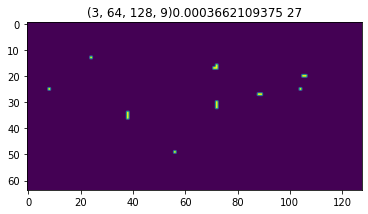

In [103]:
plt.imshow(np.max(positive_maps[0][0], -1))
plt.title(str(positive_maps[0].shape)+ str(np.mean(positive_maps[0][0]))+ ' ' + str(np.sum(positive_maps[0][0])))

In [104]:
pmap0 = np.array(Image.fromarray(np.max(positive_maps[0][0],-1)).resize((image_width, image_height)))
pmap1 = np.array(Image.fromarray(np.max(positive_maps[1][0],-1)).resize((image_width, image_height)))
pmap2 = np.array(Image.fromarray(np.max(positive_maps[2][0],-1)).resize((image_width, image_height)))
#pmap3 = np.array(Image.fromarray(np.max(positive_maps[3][0],-1)).resize((image_width, image_height)))
#pmap4 = np.array(Image.fromarray(np.max(positive_maps[4][0],-1)).resize((image_width, image_height)))
pmap0 = pmap0.astype(np.uint8)
pmap1 = pmap1.astype(np.uint8)
pmap2 = pmap2.astype(np.uint8)
pmap3 = 0#pmap3.astype(np.uint8)
pmap4 = 0#pmap4.astype(np.uint8)

Text(0.5, 1.0, '0.0030517578125')

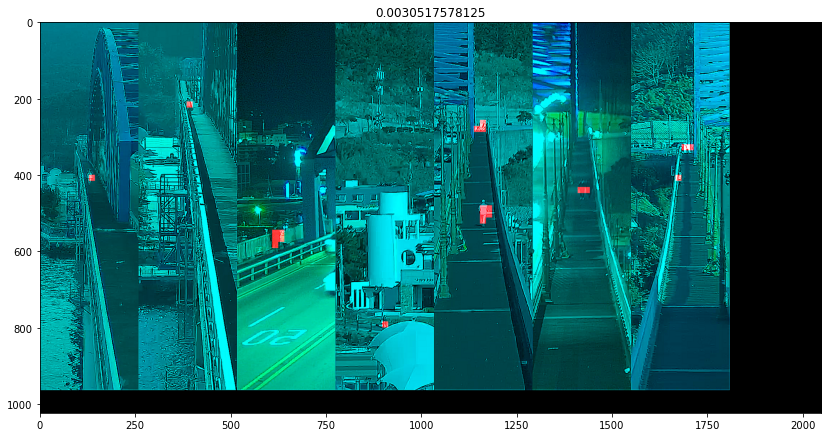

In [105]:
pmap_with_img = np.array(img_check)[0]#*255
pmap_with_img = pmap_with_img.astype(np.uint8)
pmap_add = np.expand_dims(pmap0+pmap1+pmap2+pmap3+pmap4, -1)
pmap = (pmap_add>0).astype(np.uint8)*255
mix_rgb = np.concatenate((pmap, pmap_with_img[:,:,1:]),-1)
plt.figure(figsize=(14,14))
plt.imshow(mix_rgb)
plt.title(str(np.mean(pmap_add)))

In [106]:
def load_weight():   
    weights_dir = path_weight#"data"
    #latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    latest_checkpoint = weights_dir 
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(weights_dir)

In [107]:
num_classes, num_classes_real, len(class_names)

(14, 4, 4)

In [108]:
#optimizer = tf.optimizers.SGD(learning_rate=1e-5, momentum=0.1, clipvalue=5.)#warm up clipvalue=10. !
optimizer = tf.optimizers.SGD(learning_rate=1e-4, momentum=0.1, clipvalue=10.)
loss_detect = RetinaNetLoss(len(class_names))
model = createRetinaNet(num_classes, anchor_k)
metrics = [recall, precision, acc]#, gender_acc, body_acc, up_cloth_acc]
model.compile(loss=loss_detect, optimizer=optimizer, metrics=metrics)#[recall, precision, accuracy]
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=path_weight,
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=0,
        save_freq=200
    )
]

In [109]:
model.summary()#21,571,620 > 15,241,650 , D3 : 8,386,848 > BIFPN > 9,601,568, 9,721,632,  8,506,912

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, None, None,  6887029     input_2[0][0]                    
__________________________________________________________________________________________________
a55 (Conv2D)                    (None, None, None, 2 59648       model[0][3]                      
__________________________________________________________________________________________________
a44 (Conv2D)                    (None, None, None, 2 35072       model[0][2]                      
____________________________________________________________________________________________

In [110]:
load_weight()

latest_checkpoint weight/pedestrian_efficientDet-D3


In [111]:
print(len(input_list_train), len(input_list_test))#3784 > 3894

4797 1892


In [ ]:
'''
resnet-34  81ms/step, resnet-24  53ms/step
efficientB0  :  63ms/step - loss: 1.5916 - recall: 0.9155 - precision: 0.9330 - accuracy: 0.8751
eff-D7 Freeze: 182ms/step - loss: 2.1849 - recall: 0.9470 - precision: 0.9660 - accuracy: 0.9055 - flip_accuracy: 0.0052
eff-D2 Freeze:  51ms/step - loss: 1.3613 - recall: 0.8868 - precision: 0.9013 - acc: 0.9219
eff-D2 Fine  : 107s 56ms/step - loss: 1.2497 - recall: 0.9278 - precision: 0.8723 - acc: 0.9174
eff-D2 share : 351s 54ms/step - loss: 1.2555 - recall: 0.9250 - precision: 0.8746 - acc: 0.8983
               112s 59ms/step - loss: 1.2263 - recall: 0.9277 - precision: 0.8796 - acc: 0.8793
               105s 55ms/step - loss: 1.1388 - recall: 0.9398 - precision: 0.8761 - acc: 0.9047
               103s 54ms/step - loss: 1.1593 - recall: 0.9237 - precision: 0.8890 - acc: 0.9098
eff-D3 Freeze: 58s 57ms/step - loss: 5.7616 - recall: 0.4938 - precision: 0.4522 - acc: 0.5991
       Fine  : 59s 57ms/step - loss: 7.2409 - recall: 0.5634 - precision: 0.6794 - acc: 0.9502
'''
out = model.evaluate(val_dataset.take(1000))

reszie 시 padding resize 하자

In [ ]:
epochs = 1000
hist = model.fit(
    train_dataset,
    validation_data=None,#val_dataset.take(2)
    epochs=epochs, 
    callbacks=callbacks_list,#callbacks_list
    verbose=1,
)
'''
effD2 Freeze:32s 474ms/step - loss: 14.7472 - recall: 0.4458 - precision: 0.6697 - accuracy: 0.0049
effD2 fine :409s 494ms/step - loss:14.2226 - recall: 0.7724 - precision: 0.8478 - accuracy: 0.0278 - gender_accuracy: 0.5578                        
      Freeze :  480s 517ms/step - loss: 4.6561 - recall: 0.9110 - precision: 0.9214 - acc: 0.3581 - gender_acc: 0.6018 - body_acc: 0.6569      
      Fine   : 1545s 1s/step - loss: 1.1143 - recall: 0.9205 - precision: 0.8567 - acc: 0.8944
      share  : 1488s 1s/step - loss: 1.1503 - recall: 0.9212 - precision: 0.8534 - acc: 0.8670
               1473s 1s/step - loss: 0.9896 - recall: 0.9347 - precision: 0.8713 - acc: 0.8920
               1869s 1s/step - loss: 0.9950 - recall: 0.9333 - precision: 0.8754 - acc: 0.9119
effD3 Freeze : 257s 1s/step - loss: 4.8396 - recall: 0.3820 - precision: 0.5429 - acc: 0.5620
      Fine   :1757s 1s/step - loss: 3.3169 - recall: 0.5763 - precision: 0.5924 - acc: 0.6170
'''

Epoch 1/1000
2399/2399 [==============================] - 8961s 3s/step - loss: 7.6354 - recall: 0.6875 - precision: 0.6736 - acc: 0.7405
Epoch 2/1000
2399/2399 [==============================] - 2099s 875ms/step - loss: 8.1963 - recall: 0.6509 - precision: 0.6586 - acc: 0.7412
Epoch 3/1000
2399/2399 [==============================] - 3244s 1s/step - loss: 8.3419 - recall: 0.6507 - precision: 0.6433 - acc: 0.7419
Epoch 4/1000
2110/2399 [=========================>....] - ETA: 4:01 - loss: 8.5343 - recall: 0.6703 - precision: 0.6628 - acc: 0.7331

- 8:20 start, 8:51~8:58 1/, 09:03 5/, 09:27 22/, 
- 15:38 start, 15:54, 3/Unknown, 16:02 run fast(takes 24 minites) 

야간 배경 오탐지 많음, 다음주 화요일 아침까지 전달하자, 다음주 수목금 통영 출장

In [ ]:
model.save_weights(path_weight)
path_weight

In [ ]:
#image = tf.keras.Input(shape=[padded_image_shape[0], padded_image_shape[1], 3], name="image")
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)

detections = decodePredictions(image, predictions, confidence_threshold=0.5, nms_iou_threshold=0.2)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [ ]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(12, 10), linewidth=1, color=[0, 0, 1], 
    boxes_gt=None):
    
    image = np.array(image, dtype=np.uint8)
    image = attach_crop_image(image, boxes, max_crop=200)        
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()        
   
    if boxes_gt is not None:
        for box in boxes_gt:        
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            patch = plt.Rectangle(
                [x1, y1], w, h, fill=False, edgecolor=[0,1,0], linewidth=2
            )
            ax.add_patch(patch)
            
    for box, cls, score in zip(boxes, classes, scores):        
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        color_text = edgecolors[cls]
        color = [0, 0, 1]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 100:
            score_txt = str.format('(%d)%.2f' %(cls, score))
            ax.text(x1, y1, score_txt, bbox={"facecolor": color_text, "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
          
    plt.show()
    return ax

In [ ]:
def check_test(test_datas, bboxs_label, step=1):
    i = 0
    for image, cbbox in test_datas: 
        if i%step==0:            
            bbox_annotation = bboxs_label[i]
            scale = np.array(image.shape[:2])[::-1]
            scale = np.reshape(scale, [1, 2])
            scale = np.concatenate((scale, scale), 1)
            gt_bbox = bbox_annotation[ :, :4] * scale
               
            input_image, _, ratio = resize_and_pad_image(image, jitter=None)
            input_image = tf.expand_dims(input_image, axis=0)
            #input_image = tf.cast(input_image, tf.uint8)
            detected_box = inference_model.predict(input_image)
                        
            print(input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio)
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio
                        
            visualize_detections(
                image,
                box,
                cls_h,
                scores,
                boxes_gt=gt_bbox
            )
        i+=1

In [ ]:
check_test(dataset_test, bbox_list_test, step=1000)

In [ ]:
#random indexing for train
check_test(dataset, bbox_list_train, step=1000)

In [ ]:
path_test = '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/event/미수_스마트시티_통영대교_미수방향2(Ch 01)_[20201217]163000-[20201218]090000(20201217_163000)_손올리기/'
os.path.isdir(path_test)

In [ ]:
path_test = '/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/event/미수_스마트시티_통영대교_미수방향1(Ch 01)_[20201217]163000-[20201218]090000(20201217_163000)_손올리기/'
os.path.isdir(path_test)

In [ ]:
#paths_test_img = glob('/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/event/*미수방향1*/*.jpg')
paths_test_img = glob('/media/mvlab/46FA9CA2FA9C8FB3/dataset/pedestrian/Tongyoung/event/*/*.jpg')
paths_test_img = np.sort(paths_test_img)
len(paths_test_img)

In [ ]:
paths_test_img2 = []
for path in paths_test_img:
    if '마트시티_통영대교_미수방향2' in path:
        paths_test_img2.append(path)
len(paths_test_img2)

In [ ]:
def convert_label_list_to_df(list_output):
    df = pd.DataFrame(columns=['path', 'cls', 'x0', 'y0', 'x1', 'y1', 'confidence'])
    
    ratio = 0.9481481481481482
    for output in list_output:
        path_img = output[0]
        detected_box = output[1]

        for box in detected_box:
            cls_h = box[0].astype(np.int)
            scores = (box[1]*100).astype(np.int)
            box_coord = box[2:2+6]/ratio
            x0 = box_coord[0].astype(np.int)
            y0 = box_coord[1].astype(np.int)
            x1 = box_coord[2].astype(np.int)
            y1 = box_coord[3].astype(np.int)
            row = {'path':path_img, 'cls':cls_h, 'x0':x0, 'y0':y0, 'x1':x1, 'y1':y1, 'confidence':scores}
            df = df.append(row, ignore_index=True)
            
    return df

In [ ]:
def save_inference_result(paths_img):
    
    print('len', len(paths_img))
    
    list_output = []
    for i in range(len(paths_img)):
        path_img = paths_img[i]
        if i % 100 == 0:
            print(len(paths_img), i, path_img.split(os.sep)[-1])
        
        img = Image.open(path_img)
        img_arr = np.array(img)
        input_image, _, ratio = resize_and_pad_image(img_arr, jitter=None)
        input_image = tf.expand_dims(input_image, axis=0)        
        detected_box = inference_model.predict(input_image)
        
        if len(detected_box) > 0:            
            list_output.append([path_img, detected_box])
        
        if len(list_output) > 0 and len(list_output)%1000==0:
            df = convert_label_list_to_df(list_output)            
            df.to_csv('predict.csv')
    
    df = convert_label_list_to_df(list_output)            
    df.to_csv('predict.csv')
    print('finished')
            

In [ ]:
len(paths_test_img2)

In [ ]:
save_inference_result(paths_test_img2
                     )

In [ ]:
df = pd.DataFrame(columns=['path', 'cls', 'x0', 'y0', 'x1', 'y1'])

In [ ]:
df.append({'path':0, 'cls':0, 'x0':1, 'y0':0, 'x1':0, 'y1':0}, ignore_index=True)#{'A': i},

In [ ]:
check_wrong(input_list, bbox_list, annotation)

In [ ]:
def add_pad_32x_arr(image_arr):
    #print('image_arr', image_arr.shape, image_arr.dtype)
    stride = 32
    img_h = image_arr.shape[0]
    img_w = image_arr.shape[1]
    img_c = image_arr.shape[2]
    #print('add_pad_32x', image_arr.shape, img_h, img_w)
    pad_h = (stride - (img_h % stride)) % stride
    pad_w = (stride - (img_w % stride)) % stride
    padded_h = img_h + pad_h
    padded_w = img_w + pad_w
    #print('pad_h', pad_h, 'pad_w', pad_w)
    image_padded = np.zeros((padded_h, padded_w, img_c), dtype=np.uint8)
    image_padded[:img_h, :img_w] = image_arr
        
    return image_padded

In [ ]:
def check_bg(image, is_display=True, is_save=False, save_path=''):
    scale = np.array(image.shape[:2])[::-1]
    scale = np.reshape(scale, [1, 2])
    scale = np.concatenate((scale, scale), 1)

    #input_image, _, ratio = resize_and_pad_image(image, jitter=None)
    input_image = add_pad_32x_arr(image)     
    ratio = 1
    input_image = tf.expand_dims(input_image, axis=0)

    detected_box = inference_model.predict(input_image)        
    if len(detected_box) > 0:
        #print(input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio)
        #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
        if is_display:
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio

            visualize_detections(
                image,
                box,
                cls_h,
                scores                
            )
        if is_save:
            img = Image.fromarray(image)
            img.save(save_path +'.jpg')
        else:
            pass
    return int(len(detected_box)>0)

In [ ]:
list_jpg = glob(folder_water_bg + '*')
print(len(list_jpg))

In [ ]:
wrong = 0
for i in range(0, len(list_jpg)//1):    
    jpg = list_jpg[i]
    #print('i', i, jpg.split(os.sep)[-1])
    img = Image.open(jpg)
    arr = np.array(img)
    
    n = check_bg(arr, is_display=True)
    if n>0:
        wrong += n
        print(wrong, i, jpg)#414/815, 348/544, 6/242, 43/1522, 59/2043, 64/2375

In [ ]:
inference_model.save('./pedestrian_efficientDet-D2_save')

avi Test

In [ ]:
import cv2
import time
def video_to_frames(input_loc):
    """Function to extract frames from input video file
    and save them as separate frames in an output directory.
    Args:
        input_loc: Input video file.
        output_loc: Output directory to save the frames.
    Returns:
        None
    """
        
    folder_split = input_loc.split(os.sep)
    file_name = folder_split[-1]
    file_name = file_name.split('.')[0]
    bg_dir = os.sep.join(folder_split[:-1]) + os.sep + 'bg' + os.sep
    output_loc = bg_dir#input_loc[:-4]
    print('output_loc', output_loc)
    list_img = []
    list_path = []
    
    try:
        os.mkdir(output_loc)
    except OSError:
        pass
    # Log the time
    time_start = time.time()
    # Start capturing the feed
    cap = cv2.VideoCapture(input_loc)
    # Find the number of frames
    
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    save_count = 0
    print ("Converting video..\n")
    # Start converting the video
    
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        count = count + 1
        if count%10!=0:continue
        # Write the results back to output location.
        dst_name = output_loc +"/%s_%#05d.jpg" % (file_name, count+1)
        try:
            #cv2.imwrite(file_name, frame)
            b, g, r = np.split(frame, 3, -1)
            rgb = np.concatenate((r,g,b), -1)        
            
            list_img.append(rgb)
            list_path.append(file_name + '_' + str(save_count))
            save_count += 1
        except:
            print('except')
            break
        
        # If there are no more frames left
        if count%100==0:
            print('count', video_length, count)
        if (count > (video_length*0.9)):
            # Log the time again
            break
    
    time_end = time.time()
    # Release the feed
    cap.release()
    # Print stats
    print ("Done extracting frames.\n%d frames extracted" % count)
    print ("It took %d seconds to save %d for conversion ." % (time_end-time_start, save_count))

    return list_img, list_path

In [ ]:
folder_avi = '/home/mvlab/Downloads/dataset/water_movie_obj/'
file_avi = folder_avi +'20201031-100620~20201031-100820_대야리2_332874518.avi'
os.path.isdir(folder_avi), os.path.isfile(file_avi)

In [ ]:
folder_bg_avi = '/home/mvlab/Downloads/dataset/water_movie_bg/'
path_bg_avi = glob(folder_bg_avi + '*.avi' )
if len(path_bg_avi)>0:
    file_avi = path_bg_avi[0]
    print('file_avi', file_avi)
os.path.isdir(folder_bg_avi), os.path.isfile(file_avi), len(path_bg_avi)

list_avi_arr, list_avi_path = video_to_frames(file_avi)

In [ ]:
folder_water_bg

In [ ]:
folder_new_bg = '/home/mvlab/Downloads/dataset/water_movie_bg/bg0/'

In [ ]:
wrong = 0
for j in range(34, len(path_bg_avi)):
    file_avi = path_bg_avi[j]
    print('open_video',len(path_bg_avi), j, file_avi)
    list_avi_arr, list_avi_path = video_to_frames(file_avi)
    
    for i in range(1, len(list_avi_arr), 1):    
        arr = list_avi_arr[i]    
        filename = folder_new_bg + list_avi_path[i]    
        wrong += check_bg(arr, is_display=False, is_save=True, save_path=filename)
        if i%100==0:
            print(j, len(list_avi_arr), i, wrong)#414 815, 348 544
    list_avi_arr.clear()
    list_avi_path.clear()

Freeze Model

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [ ]:
 # Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: inference_model(x))
full_model = full_model.get_concrete_function(
    x=tf.TensorSpec(inference_model.inputs[0].shape, inference_model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]


In [ ]:
print(type(frozen_func.outputs))
frozen_list = frozen_func.outputs
print(frozen_list)
print(len(frozen_list))

print(type(frozen_func.inputs))
frozen_list = frozen_func.inputs
print(frozen_list)
print(len(frozen_list))

In [ ]:
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="pedestrian_efficientDet-D2_frozen_graph.pb",
                  as_text=False)

In [ ]:
def check_error(X, Y, Path, step=1):
    
    for i in range(len(X)): 
        image = X[i]
        bbox_annotation = Y[i]
        path = Path[i]
        
        scale = np.array(image.shape[:2])[::-1]
        scale = np.reshape(scale, [1, 2])
        scale = np.concatenate((scale, scale), 1)
        gt_bbox = bbox_annotation[:, 1:] * scale

        input_image, _, ratio = resize_and_pad_image(image, jitter=None)
        input_image = tf.expand_dims(input_image, axis=0)

        detected_box = inference_model.predict(input_image)
        detect_k = len(detected_box)
        if detect_k!= len(bbox_annotation):
            print(path, input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio.numpy())
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio
            #print('box', box)

            visualize_detections(
                image,
                box,
                cls_h,
                scores,
                boxes_gt=gt_bbox
            )
        

In [ ]:
start = 1000
end = start + 100
check_error(input_list[start:end], bbox_list[start:end], path_list[start:end])

## load model from .pb file

In [ ]:
saved_model_pb = './pedestrian_efficientDet-D2'

In [ ]:
inference_model.save(saved_model_pb)

In [ ]:
custom_objects = {'recall':recall,'precision':precision}
model_loaded = keras.models.load_model(saved_model_pb, custom_objects=custom_objects, compile=False)
#model_loaded.summary()

In [ ]:
model_loaded.compile()

In [ ]:
for image, cbbox in val_dataset: 
    
    detected_box = model_loaded.predict(image)
    print('detected_box', detected_box.shape)
    if len(detected_box) > 0:
        cls_h = detected_box[:, 0].astype(np.int)
        scores = detected_box[:, 1]
        box = detected_box[:, 2:]

        visualize_detections(
            image[0],
            box,
            cls_h,
            scores
        )    
    break

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_pb)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter

In [ ]:
tflite_model = converter.convert()

In [ ]:
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!ls *.tflite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()

In [ ]:
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
input_details, output_details

In [ ]:
input_data = input_list_train[0]
input_data = (np.expand_dims(input_data, 0)/255).astype(np.float32)
input_data.shape

In [ ]:
input_data = input_data[:, :padded_image_shape[0], :padded_image_shape[1]]
input_data.shape, np.max(input_data)

In [ ]:
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print('input_data', input_data.shape)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
tflite_results.shape

In [ ]:
tflite_results[0]

In [ ]:
detected_box = tflite_results
cls_h = detected_box[:, 0].astype(np.int)
scores = detected_box[:, 1]
box = detected_box[:, 2:] / ratio
#print('box', box)

visualize_detections(
    input_data[0]*255,
    box,
    cls_h,
    scores,
)

In [ ]:
glob('/home/mvlab/Downloads/dataset/통영/label_noise/*')